# <center>Computer Vision : Assignment -1</center>

# Importing the required Libraries 

In [1]:
import numpy as np
import cv2
import random
from scipy import linalg
import os
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Finding image co-ordinates manually

For Applying Direct Linear Transformation(DLT) and Ransac Methods to calculate the P matrix we will need some image points corresponding to world co-ordinates. Below code is taken from https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/ .

In [2]:
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, ' ', y)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' + str(y), (x,y), font, 1, (255, 0, 0), 2)
        cv2.imshow('image', img)
    if event==cv2.EVENT_RBUTTONDOWN:
        print(x, ' ', y)
        font = cv2.FONT_HERSHEY_SIMPLEX
        b = img[y, x, 0]
        g = img[y, x, 1]
        r = img[y, x, 2]
        cv2.putText(img, str(b) + ',' + str(g) + ',' + str(r),(x,y), font, 1,(255, 255, 0), 2)
        cv2.imshow('image', img)

As the size of the image is large, we will need to scale down the image so that we can find the image co-ordinate and after finding image co-ordinates we will scale up the image co-ordinates by the same factor we used to down scale the image. In this case, scaling factor of (1/4) is used so we will have to multiply the image co-ordinates by 4 to get actual co-ordinates.

In [3]:
# img = cv2.imread('../data/black-dots.JPG')
# src = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# width = int(src.shape[1] * 0.25)
# height = int(src.shape[0] * 0.25)

# img = cv2.resize(src, (width, height))
# cv2.imshow('image', img)
# cv2.setMouseCallback('image', click_event)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [4]:
X = [0,0,36,36,72,72,108,108,144,144,180,180,216,216,0,0,36,36,72,72,108,108,144,144,180,180]
Y = [36,72,36,72,36,72,36,72,36,72,36,72,36,72,0,0,0,0,0,0,0,0,0,0,0,0]
Z = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,72,36,72,36,72,36,72,36,72,36,72]

x = [1218,1231,1010,1016,806,810,611,609,420,415,233,225,50,35,1185,1161,967,932,760,711,558,496,360,287,167,84]
y = [351,144,334,130,320,118,308,109,293,97,280,85,263,73,616,697,597,678,579,657,561,639,541,616,528,601]

#Scaling x and y as we have scale downed the image for extracting image co-ordinates
x = [4*i for i in x]
y = [4*i for i in y]

world_points = [[i,j,k] for i,j,k in zip(X,Y,Z)]
image_points = [[i,j] for i,j in zip(x,y)]

world_points = np.array(world_points)
image_points = np.array(image_points)

# 1. Direct Linear Transformation (DLT)
In Direct Linear Transformation we take 6 world coordinates and corresponding image coordinates. Then we try to solve the x = PX to estimate the value of Projection Matrix(P).

### Decomposing P matrix
Once we find the Projection Matrix(P) (P is a 3x4 matrix), we can now easily find the intrensic and Extrensic paramters of the Camera. From P matrix we will find camera matrix(K), Rotation Matrix(R) and Translation Matrix(t). To calcualte K, we will equate MM<Sup>T</Sup> = KK<Sup>T</Sup> where M is the matrix with 1<sup>st</sup> three column of the P matrix. Once K is calcualted we will find R and t by R = K<Sup>-1</Sup>M and t = K<Sup>-1</Sup>p4 where p4 is 4<sup>th</sup> column of the P matrix.

In [5]:
def decomposeP(P):
    try:
        #spilliting matrix into P = [M p4]
        M = P[:,0:3]
        p4 = P[:,3]

        #Finding MMT (MT-transpose of M) and normalzing it and equating it with KKT (K*transpose of K) to find
        # a,b,y,u0,v0 for the camera matrix
        MMT = np.matmul(M,M.T)
        MMT = MMT/MMT[2][2]

        u0 = MMT[0][2]
        v0 = MMT[1][2]
        b = np.sqrt(MMT[1][1] - (v0*v0))
        y = (MMT[0][1] - (u0*v0))/b
        a = np.sqrt(MMT[0][0] - (u0*u0) - (y*y))

        K = np.zeros((3,3))
        K[0][0] = a
        K[0][1] = y
        K[0][2] = u0
        K[1][1] = b
        K[1][2] = v0
        K[2][2] = 1

        #Finding R = inv(K)*M
        R = np.matmul(np.linalg.inv(K),M) 

        #Finding t = inv(K)*p4
        t = np.matmul(np.linalg.inv(K), p4)
        return K,R,t
    except:
        return None,None,None

### Finding Error
Once we calculate P, we can now check how accuarate the matrix P is using root mean squared error(rmse). We fill now find the image coordinates using the P matrix by multiply it with the world coordinates and we will find the rsme by calculating difference between new value and original value.

In [6]:
def error(P):
    dummy_world = np.concatenate((world_points.T, np.ones((1,world_points.shape[0]))))
    image_pred = np.matmul(P,dummy_world)
    image_pred = image_pred/image_pred[2]
    e = np.sqrt(np.mean(np.sum((image_points - image_pred[0:2].T)**2,1)))
    return e

### Applying Direct Linear Transformation
We have 6 world coordinates and their cooresponding image coordinates, using this we will get 12 equations with 12 unknown namely p<sub>11</sub>,p<sub>12</sub>,p<sub>13</sub>............p<sub>34</sub>. Now we will use Singular Value Decomposition(SVD)to get our P matrix. On applying SVD on the matrix we get three 3 matrixes namely u,s,v. Last index of v matrix will conatin the element of P matrix. After getting the P matrix we will normalize the matrix by dividing all the elements by P[3][4] as P[3][4] is always equal to 1 for any projection matrix.

In [7]:
def DirectLinearTranformation(world, image):
    n = world.shape[0]
    
    mat = []
    for i in range(n):
        x = world[i,0]
        y = world[i,1]
        z = world[i,2]
        u = image[i,0]
        v = image[i,1]
        
        mat.append([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
        mat.append([0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v])
        
    u,s,v = np.linalg.svd(mat)
    
    P = v[11]/v[11][11]
    P = P.reshape(3,4)
    
    K,R,t = decomposeP(P)
    e = error(P)
    
    return P,R,K,t,e

In [8]:
np.set_printoptions(suppress=True)
P,R,K,t,e = DirectLinearTranformation(world_points[11:17],image_points[11:17])
print("\nProjection Matrix(P) = \n",P)
print("\nRotation Matrix(R) = \n",R)
print("\nCamera Matrix(K) = \n",K)
print("\n Translation Matrix(t) = ",t)
print("\n Root Mean Squared Eroor(rmse) = ",e)


Projection Matrix(P) = 
 [[ -21.05702385   -1.79769277  -12.16815735 4821.0914047 ]
 [  -1.33014647  -22.37624668    2.45620134 2192.60060317]
 [   0.00033643   -0.00080505   -0.00208952    1.        ]]

Rotation Matrix(R) = 
 [[-0.00222819  0.0000893  -0.00039316]
 [-0.00022218 -0.00211455  0.00077892]
 [ 0.00033643 -0.00080505 -0.00208952]]

Camera Matrix(K) = 
 [[10052.40264332  -194.68099514  3859.38378535]
 [    0.          9658.77259088  2425.06018406]
 [    0.             0.             1.        ]]

 Translation Matrix(t) =  [ 0.09520333 -0.0240672   1.        ]

 Root Mean Squared Eroor(rmse) =  61.55084841137165


### Drawing Wireframes to check the accuracy of the result of the DLT Method

In [9]:
def wireframe(P):
    
    img = cv2.imread('../data/black-dots.JPG')
    
    for i in range(7):
        for j in range(3):
            X1 = np.array([36*i,36*j,0,1])
            X2 = np.array([36*i,36*(j+1),0,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "green")

    for i in range(3):
        for j in range(6):
            X1 = np.array([36*j,36*i,0,1])
            X2 = np.array([36*(j+1),36*i,0,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "green")

    for i in range(6):
        for j in range(6):
            X1 = np.array([36*i,0,36*j,1])
            X2 = np.array([36*i,0,36*(j+1),1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "green")


    for i in range(6):
        for j in range(6):
            X1 = np.array([36*i,0,36*j,1])
            X2 = np.array([36*(i+1),0,36*j,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "green")

    plt.imshow(img)
    plt.show()

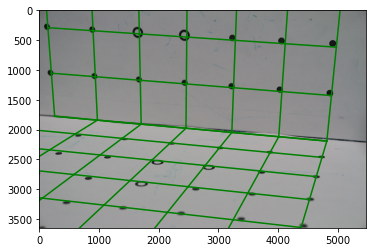

In [10]:
wireframe(P)

# 2. RANSAC Method

RANSAC method is simply a refined version of DLT method in which we apply DLT on random choosen 6 from pool of points and then try to minimize the error so we can get more accuarte P matrix as compared to what we got from DLT method. We will apply the DLT method 100 times on 6 random points from the set of points and find the error for each P matrix.The P matrix which will give us least error will be our best approximation of P matrix.

In [11]:
def RANSAC(world_pool, image_pool, iterations):
    
    final_p, final_R, final_t, final_K, final_e = 0,0,0,0,1000000
    
    index_li = [i for i in range(len(world_pool))]
    
    world_pool_t = world_pool.T
    image_pool_t = image_pool.T
    
    for i in range(iterations):
        rand_set = random.sample(index_li,6)
        world_c = []
        image_c = []
        for j in rand_set:
            world_c.append(world_pool[j])
        for j in rand_set:
            image_c.append(image_pool[j])
        world_c = np.array(world_c)
        image_c = np.array(image_c)
        p,R,K,t,e = DirectLinearTranformation(world_c,image_c)
        print("Iteration no : ",i+1)
        print("Error : ",e)
        print()
        if e<final_e:
            final_p = p
            final_R = R
            final_K = K
            final_t = t
            final_e = e
    
    return final_p, final_R, final_K, final_t, final_e

In [12]:
np.set_printoptions(suppress=True)
P,R,K,t,e = RANSAC(world_points,image_points,100)
print("\nProjection Matrix(P) = \n",P)
print("\nRotation Matrix(R) = \n",R)
print("\nCamera Matrix(K) = \n",K)
print("\n Translation Matrix(t) = ",t)
print("\n Root Mean Squared Eroor(mse) = ",e)

Iteration no :  1
Error :  47.83362929958377

Iteration no :  2
Error :  13.816159105940093

Iteration no :  3
Error :  2047.693819639858

Iteration no :  4
Error :  1411.8216344558627

Iteration no :  5
Error :  2296.340043509079

Iteration no :  6
Error :  15.734797960749027

Iteration no :  7
Error :  1632.8012219397674

Iteration no :  8
Error :  13.628741358485808

Iteration no :  9
Error :  2018.7653094840223

Iteration no :  10
Error :  1843.0389959690976

Iteration no :  11
Error :  63.35885012746499

Iteration no :  12
Error :  55.776964682973215

Iteration no :  13
Error :  1336.827619544879

Iteration no :  14
Error :  97.04822699845522

Iteration no :  15
Error :  9.906549039875973

Iteration no :  16
Error :  1247.2676954509766

Iteration no :  17
Error :  16.285355163082844

Iteration no :  18
Error :  1228.4268578007827

Iteration no :  19
Error :  17.552116191851578

Iteration no :  20
Error :  17.097251122332217

Iteration no :  21
Error :  2047.4262421018827

Iteratio

### Drawing Wireframes to check the accuracy of the result of the RANSAC method

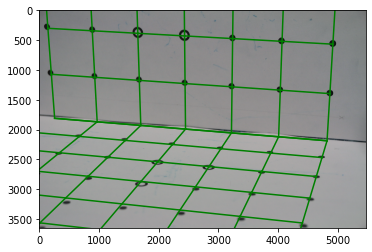

In [13]:
wireframe(P)

# 3. Radial Distortion
Over objective is to find the radial distortion in a image and remove it. To find the radial distortion using OpenCV i have used <i>left.jpg</i> image present in the <i>data</i> folder. To find radial distortion we have to find the distortion co-efficient using calibrateCamera method of openCV. The calibrateCamera method takes world points and image points as input as return the reprojection error, camera matrix, distortion co-efficient , Rotation vector and translation vectors. Once we get the camera matrix we can use undistort method of OpenCV to remove the radial distorion from the image.

In [14]:
def radialDistortion():
        
    img = cv2.imread('../data/left.jpg')
    worldp = []
    imagep = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)
    if ret == True:
        worldp.append(obj)
        imagep.append(corners)

    image = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    print("Distorted Image")
    plt.imshow(image)

    ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera(worldp, imagep, gray.shape[::-1], None, None)
    
    return ret, matrix, distortion, r_vecs, t_vecs 

Distorted Image

Camera Matrix (K) = 
 [[645.43616756   0.         198.28311436]
 [  0.         663.8530871  173.40167152]
 [  0.           0.           1.        ]]

Re-projection error =  0.25148401562850087

Distortion Coefficient =  [[-0.38612936 -0.9892724   0.01107767  0.00889097  5.31633635]]


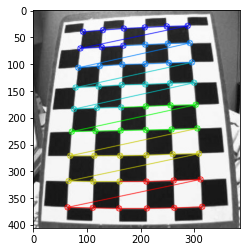

In [15]:
frameSize = (386,406)
chessboardSize = (6,9)
obj = []
for i in range(9):
    for j in range(6):
        obj.append([j,i,0])
obj = np.array(obj, np.float32)

ret, K, dist, r_vecs, t_vecs = radialDistortion()
np.set_printoptions(suppress=True)
print("\nCamera Matrix (K) = \n",K)
print("\nRe-projection error = ",ret)
print("\nDistortion Coefficient = ",dist)

Undistorted Image


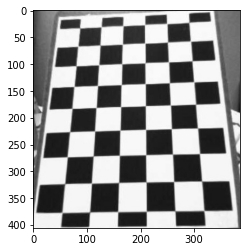

In [16]:
image = cv2.imread("../data/left.jpg")
undistorted_image = cv2.undistort(image, K, dist, None, K)
print("Undistorted Image")
plt.imshow(undistorted_image)
plt.show()

# 4. Zhang's Method 
Zhang's method of camera calibration uses the chess board taken from some camera to find the intrensic parameter of the camera. Zhang Method takes the images of chess board and find the corners of each block and 

### FInding the parameters

In [17]:
def Zhang():
    
    images = glob.glob('../data/checkerboard*.JPG')
    images.sort(key = lambda x: int(x[x.find('-')+1:x.find('J')-1]))
    
    worldp = []
    imagep = []
    
    for image in images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)
        if ret == True:
            worldp.append(obj)
            imagep.append(corners)

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(worldp, imagep, frameSize, None, None)
    
    return ret, K, dist, rvecs, tvecs

In [18]:
frameSize = (5472,3648)
chessboardSize = (6,8)
obj = []
for i in range(8):
    for j in range(6):
        obj.append([j,i,0])
obj = np.array(obj, np.float32)

ret, K, dist, rvecs, tvecs = Zhang()
np.set_printoptions(suppress=True)
print("\nCamera Matrix (K) = \n",K)
print("\nRe-projection error = ",ret)
print("\nDistortion Coefficient = ",dist)


Camera Matrix (K) = 
 [[13663.48155243     0.          3336.51257091]
 [    0.         13681.38881884  1496.57972761]
 [    0.             0.             1.        ]]

Re-projection error =  2.481022249752459

Distortion Coefficient =  [[   0.0951409    10.11504547   -0.01527973    0.0287204  -160.70147253]]


### Drawing the Wireframes on the checkerboard images

In [19]:
def drawWireframes():
    for i in range(1,16):
        imgpoints_new, _ = cv2.projectPoints(obj, rvecs[i-1], tvecs[i-1], K, dist)
        l = []
        for j in imgpoints_new:
            l.append(j[0])
        l = np.array(l)
        if i<10:
            f = "0" + str(i)
        else:
            f = str(i)

        filename = "../data/checkerboard-"+ f+ ".JPG"
        image = cv2.imread(filename)
        x1 = l[:,0]
        x2 = l[:,1]
        
        for i in range(8):
            temp1 = x1[6*i:6*(i+1)]
            temp2 = x2[6*i:6*(i+1)]
            for j in range(5):
                plt.plot((temp1[j],temp1[j+1]),(temp2[j],temp2[j+1]), color = "yellow")
                
        for i in range(6):
            temp1 = []
            temp2 = []
            for k in range(8):
                temp1.append(x1[6*k+i])
            for k in range(8):
                temp2.append(x2[6*k+i])
            for j in range(7):
                plt.plot((temp1[j],temp1[j+1]),(temp2[j],temp2[j+1]), color = "yellow")
        plt.scatter(l[:,0],l[:,1], color = "blue")

        print(filename)
        plt.imshow(image)
        plt.show()

../data/checkerboard-01.JPG


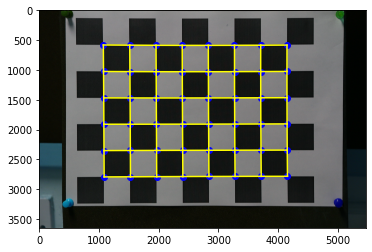

../data/checkerboard-02.JPG


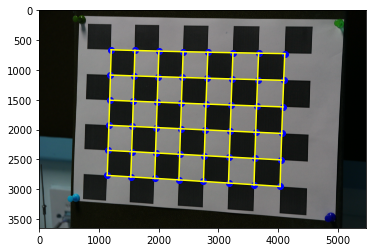

../data/checkerboard-03.JPG


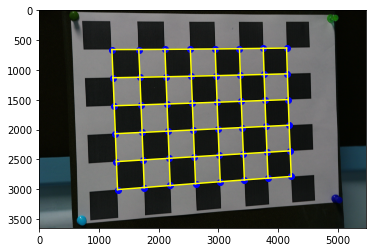

../data/checkerboard-04.JPG


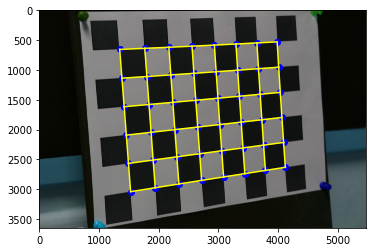

../data/checkerboard-05.JPG


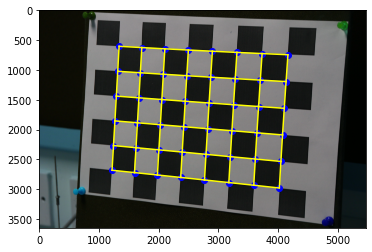

../data/checkerboard-06.JPG


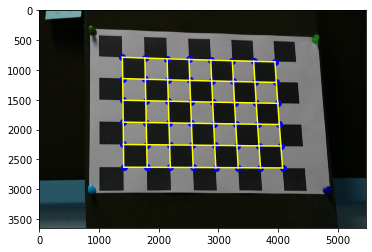

../data/checkerboard-07.JPG


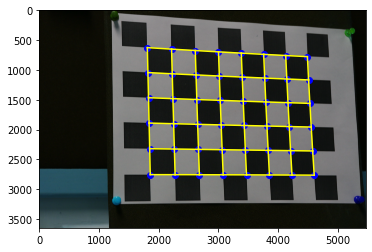

../data/checkerboard-08.JPG


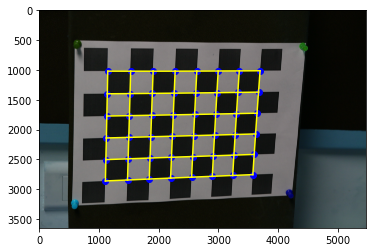

../data/checkerboard-09.JPG


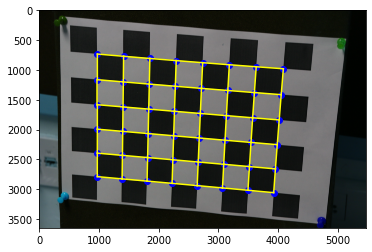

../data/checkerboard-10.JPG


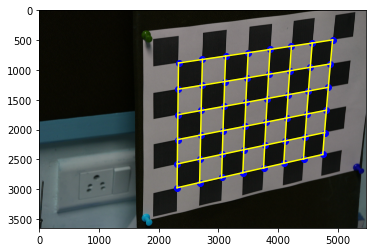

../data/checkerboard-11.JPG


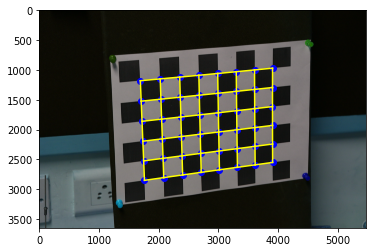

../data/checkerboard-12.JPG


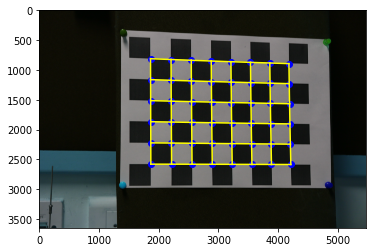

../data/checkerboard-13.JPG


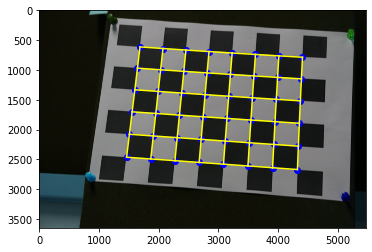

../data/checkerboard-14.JPG


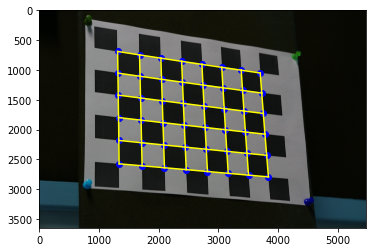

../data/checkerboard-15.JPG


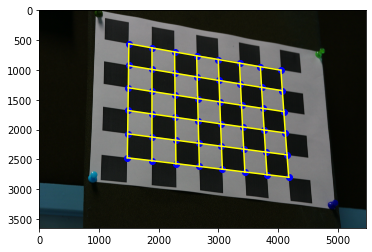

In [20]:
drawWireframes()

# 5. Image of World Origin

Image of world origin is given by fourth column(p4) of the Projection Matrix(P). The p4 co-ordinate consists the image co-ordinates of the world origin i.e. (0,0,0).
        <br>x = PX</br>
        x = [p1 p2 p3 p4] [X Y Z 1].T
        <br>co-ordinates of world origin is (0,0,0)
        <br>so  x = [p1 p2 p3 p4] [0,0,0,1],.T
        <br>if we multiply both above matries we will get x = p4
         <br>where x is image co-ordinates of world origin.
         
Hence, the p4 column of P matrix represents image of world origin co-ordinates.

# 6. Experiments using images from my phone's camera 

### Finding Co-ordinates manually

In [21]:
# img = cv2.imread('../images/cube.jpg')
# src = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# width = int(src.shape[1] * 0.25)
# height = int(src.shape[0] * 0.25)

# img = cv2.resize(src, (width, height))
# cv2.imshow('image', img)
# cv2.setMouseCallback('image', click_event)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [22]:
X = [0,1,2,2,0,0,0,1,2,3,1,0,1,2,3,0,0,1,2,1,2]
Y = [0,1,2,1,1,2,3,0,0,0,2,0,0,0,0,1,2,3,3,0,0]
Z = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,2,2]

x = [747,765,769,894,614,490,389,899,1028,1135,641,765,908,1034,1134,632,512,534,672,917,1038]
y = [401,259,143,195,330,268,221,318,247,190,205,573,492,408,344,499,425,161,107,637,552]
#Scaling x and y as we have scale downed the image for extracting image co-ordinates
x = [2*i for i in x]
y = [2*i for i in y]

world_points = [[i,j,k] for i,j,k in zip(X,Y,Z)]
image_points = [[i,j] for i,j in zip(x,y)]

world_points = np.array(world_points)
image_points = np.array(image_points)

### Direct Linear Transformation (DLT)

In [23]:
np.set_printoptions(suppress=True)
P,R,K,t,e = DirectLinearTranformation(world_points[[1, 2, 9, 10, 11,16]],image_points[[1, 2, 9, 10, 11,16]])
print("\nProjection Matrix(P) = \n",P)
print("\nRotation Matrix(R) = \n",R)
print("\nCamera Matrix(K) = \n",K)
print("\n Translation Matrix(t) = ",t)
print("\n Root Mean Squared Eroor(rmse) = ",e)


Projection Matrix(P) = 
 [[ 396.01908291 -208.06667911   59.63568791 1518.61322202]
 [-118.97442201 -107.92577356  372.6198753   808.71432051]
 [   0.06409516    0.05193178    0.03132627    1.        ]]

Rotation Matrix(R) = 
 [[ 0.05607443 -0.06810851 -0.00182288]
 [-0.02310633 -0.02123101  0.08247288]
 [ 0.06409516  0.05193178  0.03132627]]

Camera Matrix(K) = 
 [[4657.96649613   23.79075757 2112.10908066]
 [   0.         4594.07596771 -200.04939818]
 [   0.            0.            1.        ]]

 Translation Matrix(t) =  [-0.12853674  0.21957924  1.        ]

 Root Mean Squared Eroor(rmse) =  19.111145010531377


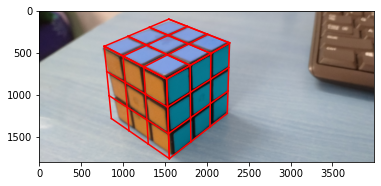

In [24]:
def wireframe(P):
    
    img = cv2.imread('../images/cube.jpg')
    
    for i in range(4):
        for j in range(3):
            X1 = np.array([i,j,0,1])
            X2 = np.array([i,j+1,0,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")
    for i in range(3):
        for j in range(4):
            X1 = np.array([i,j,0,1])
            X2 = np.array([i+1,j,0,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")
    
    for i in range(4):
        for j in range(3):
            X1 = np.array([i,0,j,1])
            X2 = np.array([i,0,j+1,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")

    for i in range(3):
        for j in range(4):
            X1 = np.array([i,0,j,1])
            X2 = np.array([i+1,0,j,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")

    for i in range(4):
        for j in range(3):
            X1 = np.array([i,j,0,1])
            X2 = np.array([i,j+1,0,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")
            
    for i in range(4):
        for j in range(3):
            X1 = np.array([0,i,j,1])
            X2 = np.array([0,i,j+1,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")
            
    for i in range(3):
        for j in range(4):
            X1 = np.array([0,i,j,1])
            X2 = np.array([0,i+1,j,1])
            p1 = np.matmul(P,X1)
            p2 = np.matmul(P,X2)
            p1 = p1/p1[2]
            p2 = p2/p2[2]
            plt.plot((p1[0],p2[0]),(p1[1],p2[1]), color = "red")

    plt.imshow(img)
    plt.show()
wireframe(P)

### RANSAC method

In [25]:
np.set_printoptions(suppress=True)
P,R,K,t,e = RANSAC(world_points,image_points,100)
print("\nProjection Matrix(P) = \n",P)
print("\nRotation Matrix(R) = \n",R)
print("\nCamera Matrix(K) = \n",K)
print("\n Translation Matrix(t) = ",t)
print("\n Root Mean Squared Eroor(rmse) = ",e)

Iteration no :  1
Error :  628.4845782719643

Iteration no :  2
Error :  100.45702187404835

Iteration no :  3
Error :  33.37870578058292

Iteration no :  4
Error :  34.70993699812825

Iteration no :  5
Error :  562.2542778571416

Iteration no :  6
Error :  13.80871369899577

Iteration no :  7
Error :  17.27444671240953

Iteration no :  8
Error :  543.289123928167

Iteration no :  9
Error :  21.162060034890246

Iteration no :  10
Error :  567.397976459381

Iteration no :  11
Error :  573.5939026063285

Iteration no :  12
Error :  30.13924793785905

Iteration no :  13
Error :  nan

Iteration no :  14
Error :  25.566627287114603

Iteration no :  15
Error :  56.0376453389802

Iteration no :  16
Error :  17.96753444005674

Iteration no :  17
Error :  14.098210273944659

Iteration no :  18
Error :  79.23163426018905

Iteration no :  19
Error :  11.062419933415253

Iteration no :  20
Error :  46.765093212960046

Iteration no :  21
Error :  12.093189755870144

Iteration no :  22
Error :  17.3

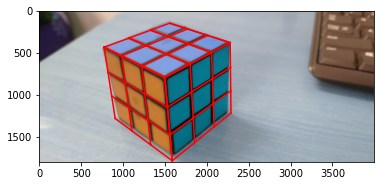

In [26]:
wireframe(P)

### Zhang's Method

In [27]:
def Zhang_on_image_taken_from_phone():
    
    images = glob.glob('../images/chess*.jpg')
    images.sort()
    
    worldp = []
    imagep = []
    count = 1
    
    for image in images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)
        count = count+1
        if ret == True:
            worldp.append(obj)
            imagep.append(corners)

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(worldp, imagep, frameSize, None, None)
    
    return ret, K, dist, rvecs, tvecs

In [28]:
frameSize = (2643,1189)
chessboardSize = (7,7)
obj = []
for i in range(7):
    for j in range(7):
        obj.append([j,i,0])
obj = np.array(obj, np.float32)

ret, K, dist, rvecs, tvecs = Zhang_on_image_taken_from_phone()
np.set_printoptions(suppress=True)
print("\nCamera Matrix (K) = \n",K)
print("\nRe-projection error = ",ret)
print("\nDistortion Coefficient = ",dist)


Camera Matrix (K) = 
 [[2607.14685524    0.         1205.25205342]
 [   0.         2608.10884823  737.64850387]
 [   0.            0.            1.        ]]

Re-projection error =  3.377742496163408

Distortion Coefficient =  [[-0.24167182 -1.72702119  0.00448448 -0.03308318  4.75037779]]


In [29]:
def drawWireframes():
    
    for i in range(1,44):
        imgpoints_new, _ = cv2.projectPoints(obj, rvecs[i-1], tvecs[i-1], K, dist)
        l = []
        for j in imgpoints_new:
            l.append(j[0])
        l = np.array(l)
        if i<10:
            f = "0" + str(i)
        else:
            f = str(i)

        filename = "../images/chess"+f+".jpg"
        image = cv2.imread(filename)
        x1 = l[:,0]
        x2 = l[:,1]
#         print(x1,x2)
        for i in range(7):
            temp1 = x1[7*i:7*(i+1)]
            temp2 = x2[7*i:7*(i+1)]
            for j in range(6):
                plt.plot((temp1[j],temp1[j+1]),(temp2[j],temp2[j+1]), color = "yellow")

        for i in range(7):
            temp1 = []
            temp2 = []
            for k in range(7):
                temp1.append(x1[7*k+i])
            for k in range(7):
                temp2.append(x2[7*k+i])
            for j in range(6):
                plt.plot((temp1[j],temp1[j+1]),(temp2[j],temp2[j+1]), color = "yellow")
        plt.scatter(l[:,0],l[:,1], color = "blue")

        print(filename)
        plt.imshow(image)
        plt.show()

../images/chess01.jpg


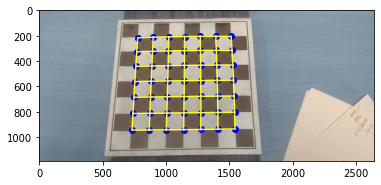

../images/chess02.jpg


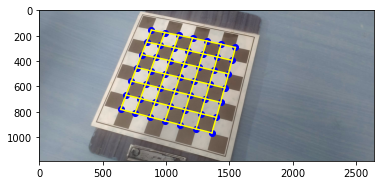

../images/chess03.jpg


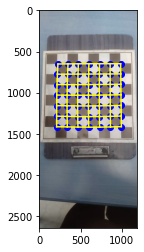

../images/chess04.jpg


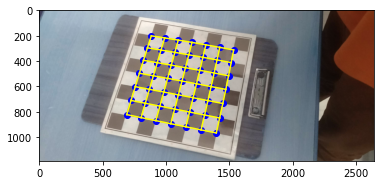

../images/chess05.jpg


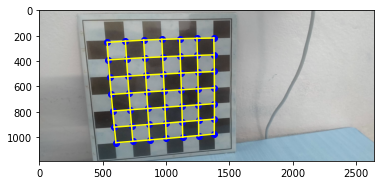

../images/chess06.jpg


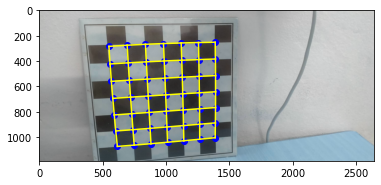

../images/chess07.jpg


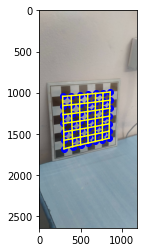

../images/chess08.jpg


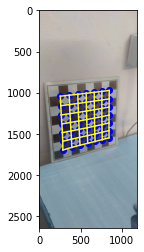

../images/chess09.jpg


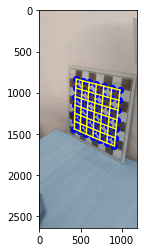

../images/chess10.jpg


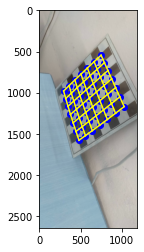

../images/chess11.jpg


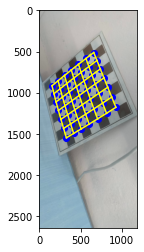

../images/chess12.jpg


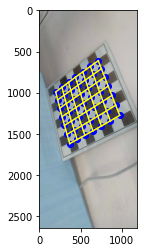

../images/chess13.jpg


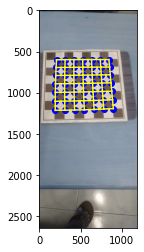

../images/chess14.jpg


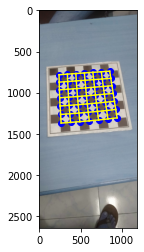

../images/chess15.jpg


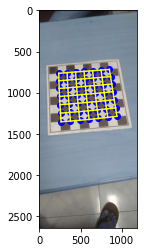

../images/chess16.jpg


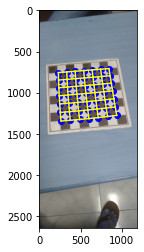

../images/chess17.jpg


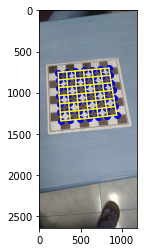

../images/chess18.jpg


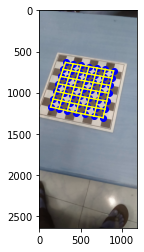

../images/chess19.jpg


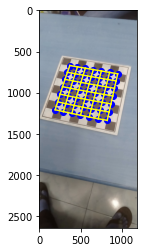

../images/chess20.jpg


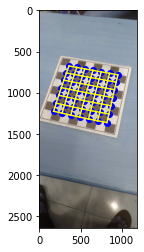

../images/chess21.jpg


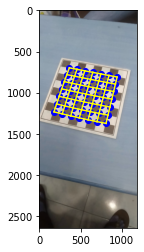

../images/chess22.jpg


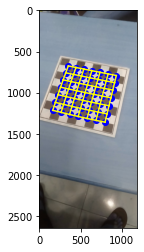

../images/chess23.jpg


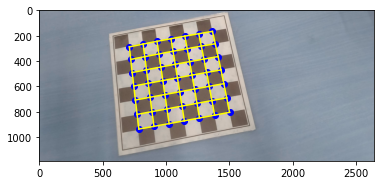

../images/chess24.jpg


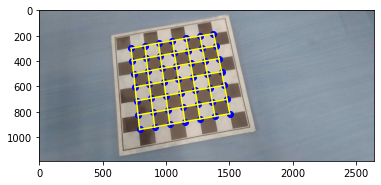

../images/chess25.jpg


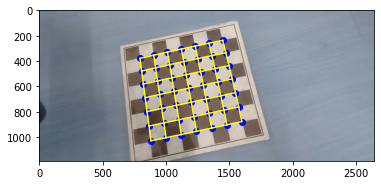

../images/chess26.jpg


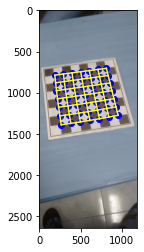

../images/chess27.jpg


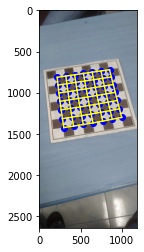

../images/chess28.jpg


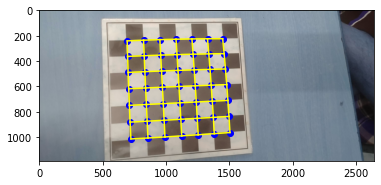

../images/chess29.jpg


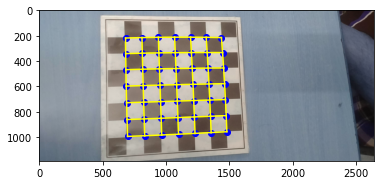

../images/chess30.jpg


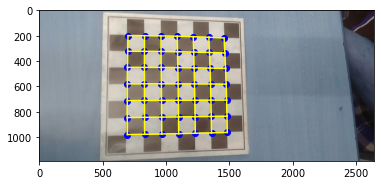

../images/chess31.jpg


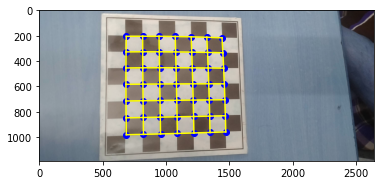

../images/chess32.jpg


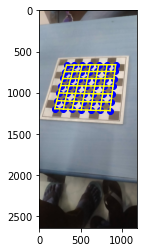

../images/chess33.jpg


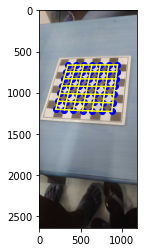

../images/chess34.jpg


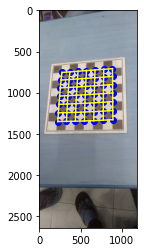

../images/chess35.jpg


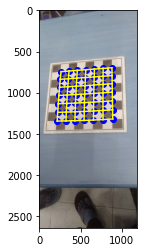

../images/chess36.jpg


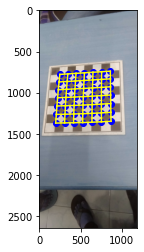

../images/chess37.jpg


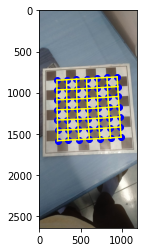

../images/chess38.jpg


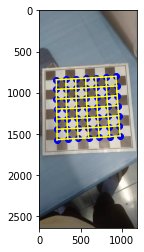

../images/chess39.jpg


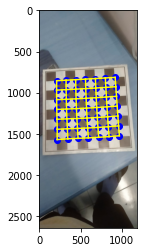

../images/chess40.jpg


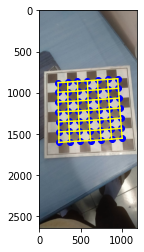

../images/chess41.jpg


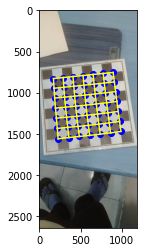

../images/chess42.jpg


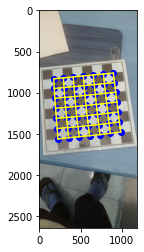

../images/chess43.jpg


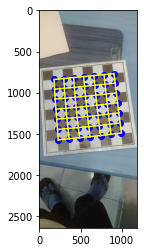

In [30]:
drawWireframes()

# Observations
- Out of the three camera calibration methods Zhang method gives us best results.
- When we compare the results from DLT and RANSAC method, it is clear that RANSAC gives more accurate result because we apply RANSAC on pool of points from which it selects random 6 points at a time and apply DLT on it. We select the P matrix for which we get least error.
- If our image co-ordinates are not accurate, then DLT will give us very bad result.
- It is not possible for us to manually find image co-ordinates accurately, so we will always get some error while calculating the projection matrix.

# Challenges
- It was difficult to find and scale the image coordinates manually.
- When using images from phone for finding the Camera Matrix using Zhang Method, It was difficult to find the chess board corners.
- Plotting wireframes accurately.

# Learnings
- Now, I can Calibrate any camera in the world by taking simple images from them. I can find the internsic and extrensic parameters of a Camera.
- Working of a camera and how 3D world is captured in 2D.
- Mathematics behind the camera.